# Histogram of Coverage and X Contamination,
using David Reichs ancient data from their annotation file.
Plot and save as .pdfs into ./figures/

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.ticker import MaxNLocator

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

VioletQueen
/home/harald/git/HAPSBURG
CPU Count: 4


# Functions to Load Data
Load from Eigenstrat Annotation File of D. Reich

In [2]:
def load_eigenstrat_anno(path="./Data/ReichLabEigenstrat/Raw/v37.2.1240K.clean4.anno", anc_only=True):
    """Load annotated Eigenstrat (from D. Reich's group)"""
    df_anno = pd.read_csv(path, sep="\t", engine="python")
    coverage = pd.to_numeric(df_anno["Coverage"], errors='coerce')
    df_anno["coverage"]=coverage

    # Convert the Ages as well
    ages = df_anno["Average of 95.4% date range in calBP (defined as 1950 CE)  "]
    df_anno["ages"] = pd.to_numeric(ages, errors='coerce')  
    
    # Convert X Contamination:
    contX = df_anno["Xcontam point estimate if male and >=200 SNPs"]
    df_anno["contX"] = pd.to_numeric(contX, errors='coerce')
    
    ### Convert Longitude and Latitude
    lat = df_anno["Lat."]
    lon = df_anno["Long."]
    df_anno["lat"] = pd.to_numeric(lat, errors='coerce')
    df_anno["lon"] = pd.to_numeric(lon, errors='coerce')
    df_anno["iid"] = df_anno["Instance ID"]
    
    df_anc = df_anno[df_anno["ages"]>0]

    print(f"Loaded {len(df_anc)} / {len(df_anno)} ancient Indivdiuals.")
    print(f"Without Coverage: {np.sum(np.isnan(coverage))}")
    if anc_only:
        df_anno=df_anc
    return df_anno


def produce_meta_csv(df_anc, save_path = "./Data/ReichLabEigenstrat/Raw/meta.csv"):
    """Produce a formatted meta .csv in my style, to streamline
    further processing (and use same machinery)"""
    ### Transfer the include_alt column
    asmts = df_anc["ASSESSMENT"]
    good = asmts.str.startswith("PASS") # the ones that pass
    bad = asmts.str.startswith("QUES")  # The ones that are "questionable" contamination
    
    assert(len(asmts)==np.sum(good) + np.sum(bad))

    include = np.zeros(len(asmts), dtype="int8")
    include[good]=1
    df_anc["ASSESSMENT"] = include # Save column

    df_save = df_anc[["iid", "lat", "lon", "ages", "Publication", "Group ID", "coverage", "SNPs hit on autosomes", 
                      "ASSESSMENT", "Sex", "contX"]]
    df_save.columns =["iid", "lat", "lon", "age", "study", "clst", "mean_cov", "n_cov_snp", "include_alt", "sex", "contX"]
    if len(save_path)>0:
        df_save.to_csv(save_path, index=False)
        print(f"Saved to {save_path}")
    return df_save

In [3]:
df_anc = load_eigenstrat_anno(path = "./Data/ReichLabEigenstrat/Raw/v37.2.1240K.clean4.anno", anc_only=True)
df_meta = produce_meta_csv(df_anc, save_path="")
#path = "./Data/ReichLabEigenstrat/Raw/meta.csv"

Loaded 2106 / 5081 ancient Indivdiuals.
Without Coverage: 2581


### Histogram of Ages

In [72]:
def hist_ages(df_meta, ax=0, fs=14, lim=[0,3.5e4], bin_step=250, figsize=(6,4), 
              xlim=[], ylim=[0,230], lw=1.0, ec="k", c="blue", savepath="", c2="maroon",
              labelpad=0, text=True, show=True):
    """Do Histogram of Sample Ages"""
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["age"])
    x_cdf = x_cdf[~np.isnan(x_cdf)]
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)
    
    bins = np.arange(lim[0], lim[1], bin_step) - 0.5 # Make 200 year bins
    ages = df_meta["age"]
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    ax=plt.gca()
    ax.hist(ages, color=c, ec=ec, bins=bins, lw=lw)
    #ax.axvline(0.5, color="red", lw=2)
    ax.set_ylim(ylim)
    if len(xlim)==0:
        xlim=lim
    ax.set_xlim(xlim)
    ax.set_xlabel("Avg. Age [years BP]", fontsize=fs)
    ax.set_ylabel("Count", fontsize=fs)
    if text:
        ax.text(x=0.37, y=0.8, 
                s=f"Total Number ancients: {len(df_anc)}", transform=ax.transAxes, fontsize=fs)
    
    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=270, fontsize=fs, labelpad=labelpad)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    if show:
        plt.show()
    else:   #### Abuse as Keyword to signal that this plot is used in summary Plot
        ax.set_xlabel("")
        ax.set_xticks([])

Saved to ./figures/manuscript/histograms/hist_ages.pdf


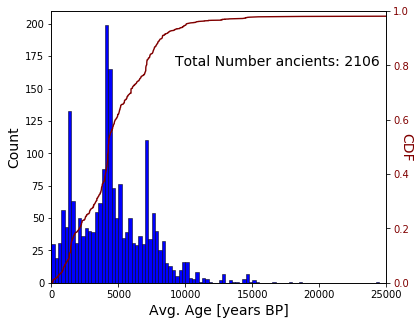

In [263]:
hist_ages(df_meta, figsize=(6,5), ec="k", c="blue", lw=0.5, ylim=[0,210], 
          lim=[0,2.5e4], savepath="./figures/manuscript/histograms/hist_ages.pdf")

### Histogram of Coverage 1240k SNPs

In [12]:
def hist_coverage(df_meta, ax=0, figsize=(8,4), c="blue", ec="k", lw=0.5, bins=[0,60], bin_step=1, 
                  xlim=[0,25], ylim=[0,500], savepath="", c2="maroon", fs=14):
    """Plot Histogram of Coverage"""
    
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["mean_cov"])
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)
 
    bins = np.arange(bins[0], bins[1], bin_step)
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax=plt.gca()
    
    ax=plt.gca()
    plt.hist(df_anc["coverage"], color=c, ec=ec, bins=bins, lw=0.5)
    ax.axvline(0.5, color="red", lw=1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    plt.xlabel(f"Avg. Coverage 1240k (bin width: {bins[1]-bins[0]:.2f})", fontsize=fs)
    plt.ylabel("Count", fontsize=fs)
    #ax.text(x=0.27, y=0.8, 
    #        s=f"Total Number ancients: {len(df_meta)}", transform=ax.transAxes, fontsize=fs)
 
    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=270, fontsize=fs)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/manuscript/histograms/hist_covs.pdf


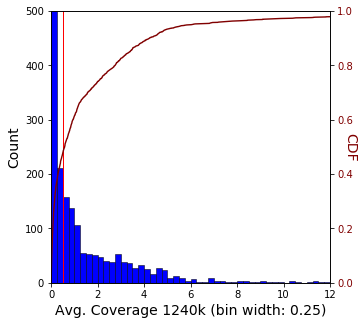

In [261]:
hist_coverage(df_meta, figsize=(5,5), bin_step=0.25, xlim=[0,12], ec="k", c="blue", 
              c2="maroon", savepath="./figures/manuscript/histograms/hist_covs.pdf")

### Histogram of X Contamination

In [259]:
def hist_xcont(df_meta, figsize=(8,4), c="blue", ec="k", lw=0.5, bins=[0,60], bin_step=1, 
                  xlim=[0,1], ylim=[0,200], savepath="", c2="maroon", fs=14):
    """Plot Histogram of Coverage"""
    
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["contX"])
    x_cdf = x_cdf[~np.isnan(x_cdf)]
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)

    bins = np.arange(bins[0], bins[1], bin_step)

    plt.figure(figsize=figsize)
    
    ax=plt.gca()
    plt.hist(df_meta["contX"], color=c, ec=ec, bins=bins, lw=lw)
    
    ax.axvline(0.5, color="red", lw=1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    plt.xlabel(f"Estimated X Cont. (bin width: {bins[1]-bins[0]:.3f})", fontsize=fs)
    plt.ylabel("Count", fontsize=fs)

    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=270, fontsize=fs)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/manuscript/histograms/hist_xcont.pdf


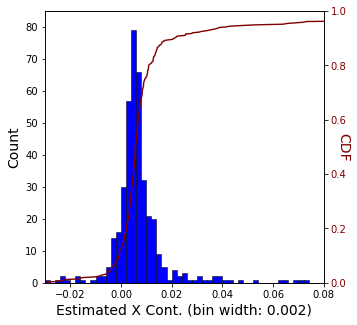

In [260]:
hist_xcont(df_meta, figsize=(5,5), bins=[-0.03,0.08], bin_step=0.002, 
           xlim=[-0.03,0.08], ylim=[0,85], ec="k", c="blue", c2="maroon", savepath="./figures/manuscript/histograms/hist_xcont.pdf")

# Do combined figure with histogram for Age & Coverage

In [150]:
##### Functions to do parts of the Plot
### Histogram Age
### Worked into above function

### Histogram 
def hist_coverage_vert(df_meta, ax=0, figsize=(8,4), c="blue", ec="k", lw=0.5, bins=[0,60], bin_step=1, 
                  xlim=[0,25], ylim=[0,500], savepath="", c2="maroon", fs=14, ax2label=False, lw_05=2):
    """Plot Histogram of Coverage"""
    
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["mean_cov"])
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)
 
    bins = np.arange(bins[0], bins[1], bin_step)
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax=plt.gca()
    
    ax=plt.gca()
    plt.hist(df_meta["mean_cov"], orientation="horizontal",
             color=c, ec=ec, bins=bins, lw=0.5)
    ax.axhline(0.5, color="red", lw=lw_05)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Count", fontsize=fs)
    ax.set_yticks([])
 
    ax2 = ax.twiny()
    ax2.plot(y_cdf, x_cdf, c=c2, lw=1.4)
    if ax2label:
        ax2.set_xlabel("CDF", color=c2, rotation=0, fontsize=fs)
        plt.setp(ax2.get_xticklabels(), color=c2)
    else:
        ax2.set_xticklabels([])
    ax2.set_xlim([0,1])
    

### Combined Figure
def scatter_age_cov(df_meta, ax, s=20, ec="k", c="blue", xlim=[0, 25000], ylim=[0,50],
                   xlabel="Age [years BP]", ylabel="Average Coverage (1240k)", fs=10):
    """Plots Scatter Plot Coverage vrs Age.
    df_meta: Gets input data from there
    ax: Axis to plot on"""
    ax.scatter(df_meta["age"], df_meta["mean_cov"], ec="k", c=c, s=s)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)

    ax.text(x=0.62, y=0.93, 
        s=f"Total Number ancients: {len(df_meta)}", transform=ax.transAxes, fontsize=fs)

In [153]:
### Call All Subfigures
def plot_anc_panel(df_meta, figsize=(9,4), fs=10, width_ratios = [6, 1],
                   height_ratios = [1, 3], wspace = 0.02, hspace = 0.04,
                   xlim_a = [-150, 20000], ylim_c = [-0.4, 10], s=18,
                   labelpad_age = 10, c="DeepPink", c2="coral", savepath=""):
    """Plot Panel with scatter plot of coverage vrs age, and the summary statistics"""
    fig=plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=width_ratios, height_ratios=height_ratios, figure=fig)
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    ax_scatter = plt.subplot(gs[1,0])
    scatter_age_cov(df_meta, ax_scatter, xlim=xlim_a, ylim=ylim_c, c=c, fs=fs, s=s)

    ax_age_hist = plt.subplot(gs[0,0])
    hist_ages(df_meta, ax_age_hist, xlim=xlim_a, labelpad=labelpad_age, text=False, 
              c=c, c2=c2, show=False, fs=fs)

    ax_cov_hist = plt.subplot(gs[1,1])
    hist_coverage_vert(df_meta, ax_cov_hist, xlim=[0,500], ylim=ylim_c, bin_step=0.25, 
                       c=c, c2=c2, fs=fs)

    ### Some final touches
    ax_scatter.xaxis.set_major_locator(MaxNLocator(prune='upper'))
    ax_scatter.yaxis.set_major_locator(MaxNLocator(prune='upper'))
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
        
    plt.show()

Saved to ./figures/manuscript/histograms/panel_hist.pdf


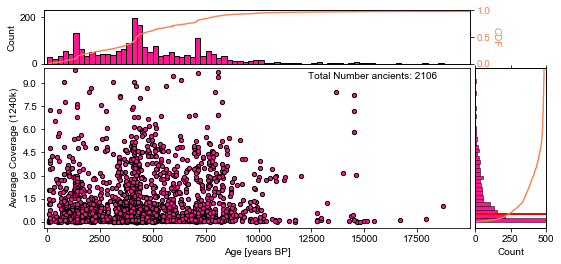

In [155]:
plot_anc_panel(df_meta, savepath="./figures/manuscript/histograms/panel_hist.pdf")

# Area 51
Test Code here